In [ ]:
from pprint import pprint
from convertmol import parse_sdf_file, bond_type_dict, single_bond_stereo_dict, double_bond_stereo_dict
from torch_geometric.data import Data
from torch_geometric.nn import *
from torch_geometric.utils import to_dense_adj, to_dense_batch, add_self_loops
from torch_geometric.nn.conv import MessagePassing
import torch
from torch import nn
import rdkit
from tqdm.auto import tqdm
import itertools
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
import sascorer
torch.set_default_device('cuda:0')#'cuda'
from rdkit.Chem.Crippen import MolLogP
from typing import List

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, dims, output_dim, activation=nn.Tanh, final_activation=nn.Tanh, dropout_rate=0.1):
        super().__init__()
        self.dims=[input_dim]+dims+[output_dim]
        self.do_rate=dropout_rate
        self.layers = nn.Sequential(
            *[
                x
                for xs in [(
                    nn.Linear(self.dims[i],self.dims[i+1]),
                    activation(),
                    nn.Dropout(self.do_rate),
                ) if i+1<len(self.dims)-1 else (
                    nn.Linear(self.dims[i],self.dims[i+1]),
                    final_activation(),
                    nn.Dropout(self.do_rate),
                ) if final_activation is not None else (
                    nn.Linear(self.dims[i],self.dims[i+1]),
                    nn.Dropout(self.do_rate),
                )  for i in range(len(self.dims)-1)]
                for x in xs
            ]
        )
    def forward(self, x):
        return self.layers(x)

In [3]:
ATOMIC_SYMBOL = {
    'H':0, 'He': 1, 'Li': 2, 'Be': 3, 'B': 4, 'C': 5, 'N': 6, 'O': 7, 'F': 8, 'Ne': 9, 
    'Na': 10, 'Mg': 11, 'Al': 12, 'Si': 13, 'P': 14, 'S': 15, 'Cl': 16, 'Ar': 17, 
    'K': 18, 'Ca': 19, 'Sc': 20, 'Ti': 21, 'V': 22, 'Cr': 23, 'Mn': 24, 'Fe': 25, 
    'Co': 26, 'Ni': 27, 'Cu': 28, 'Zn': 29, 'Ga': 30, 'Ge': 31, 'As': 32, 'Se': 33, 
    'Br': 34, 'Kr': 35, 'Rb': 36, 'Sr': 37, 'Y': 38, 'Zr': 39, 'Nb': 40, 'Mo': 41, 
    'Tc': 42, 'Ru': 43, 'Rh': 44, 'Pd': 45, 'Ag': 46, 'Cd': 47, 'In': 48, 'Sn': 49, 
    'Sb': 50, 'Te': 51, 'I': 52, 'Xe': 53, 'Cs': 54, 'Ba': 55, 'La': 56, 'Ce': 57, 
    'Pr': 58, 'Nd': 59, 'Pm': 60, 'Sm': 61, 'Eu': 62, 'Gd': 63, 'Tb': 64, 'Dy': 65, 
    'Ho': 66, 'Er': 67, 'Tm': 68, 'Yb': 69, 'Lu': 70, 'Hf': 71, 'Ta': 72, 'W ': 73, 
    'Re': 74, 'Os': 75, 'Ir': 76, 'Pt': 77, 'Au': 78, 'Hg': 79, 'Tl': 80, 'Pb': 81, 
    'Bi': 82, 'Po': 83, 'At': 84, 'Rn': 85, 'Fr': 86, 'Ra': 87, 'Ac': 88, 'Th': 89, 
    'Pa': 90, 'U': 91, 'Np': 92, 'Pu': 93, 'Am': 94, 'Cm': 95, 'Bk': 96, 'Cf': 97, 
    'Es': 98, 'Fm': 99, 'Md': 100, 'No': 101, 'Lr': 102, 'Rf': 103, 'Db': 104, 'Sg': 105, 
    'Bh': 106, 'Hs': 107, 'Mt': 108, 'Ds': 109, 'Rg': 110, 'Cn': 111, 'Nh': 112, 'Fl': 113, 
    'Mc': 114, 'Lv': 115, 'Ts': 116, 'Og': 117
}

In [4]:
BONDTYPE= {
    'UNSPECIFIED': 0,
    'SINGLE': 1,
    'DOUBLE': 2,
    'TRIPLE': 3,
    'QUADRUPLE': 4,
    'QUINTUPLE': 5,
    'HEXTUPLE': 6,
    'ONEANDAHALF': 7,
    'TWOANDAHALF': 8,
    'THREEANDAHALF': 9,
    'FOURANDAHALF': 10,
    'FIVEANDAHALF': 11,
    'AROMATIC': 12,
    'IONIC': 13,
    'HYDROGEN': 14,
    'THREECENTER': 15,
    'DATIVEONE': 16,
    'DATIVE': 17,
    'DATIVEL': 18,
    'DATIVER': 19,
    'OTHER': 20,
    'ZERO': 21,
}

bca,bc,ce->bae

$H_{bae}=E_{bca}A_{bc}X_{ce}$

In [5]:
def process_molecule_dense(m:Chem.Mol):
    conf: Chem.Conformer=m.GetConformer()
    atoms: List[Chem.Atom]=m.GetAtoms()
    bonds = m.GetBonds()
    Nv=len(atoms)
    Ne=len(bonds)
    X=torch.zeros(Nv).long()
    A=torch.zeros(Nv,Nv).long()
    E=torch.zeros(Nv,Nv,1)
    y=MolLogP(m)
    #pos=dict()
    for idx,atom in enumerate(atoms):
        X[idx]=ATOMIC_SYMBOL[atom.GetSymbol()]
        #pos[idx]=conf.GetAtomPosition(idx)
    for bond in bonds:
        i=bond.GetBeginAtomIdx()
        j=bond.GetEndAtomIdx()
        typ=BONDTYPE[str(bond.GetBondType())]
        dist=(conf.GetAtomPosition(i)-conf.GetAtomPosition(j)).Length()
        E[i,j,0]=typ
        E[j,i,0]=typ
        #E[i,j,1]=typ
        #E[j,i,1]=typ
        A[i,j]=1
        A[j,i]=1
    return E,X,A,y

In [6]:
def to_sparse(E,X,A,y):
    A=A.nonzero().T
    E=E[A[0],A[1],0].long()
    return E,X,A,y

In [7]:
from torch_geometric.nn.conv import RGCNConv
class RGCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.atom_embedding=nn.Embedding(117, 15)
        self.num_relation=22
        self.layer1 = RGCNConv(15, 10, self.num_relation)
        self.layer2 = RGCNConv(10, 12, self.num_relation)
        self.layer3 = RGCNConv(12, 6,  self.num_relation)
    def forward(self, x, edge_index, edge_attr):
        x=self.atom_embedding(x)
        out_layer1 = self.layer1(x, edge_index, edge_attr).tanh()
        out_layer2 = self.layer2(out_layer1, edge_index, edge_attr).tanh()
        out_layer3 = self.layer3(out_layer2, edge_index, edge_attr).tanh()
        return out_layer3

In [8]:
model=RGCN()
optimizer=torch.optim.AdamW(model.parameters())

In [9]:
from rdkit import Chem

In [10]:
molecules=Chem.SDMolSupplier("gdb9.sdf")
m = molecules[500]
E,X,A,y=process_molecule_dense(m)
E_sparse,_,A_sparse,_ = to_sparse(E,X,A,y)
output=model(X, A_sparse, E_sparse)
output_1_nomor=output.mean()

In [11]:
import numpy as np
e_bar=tqdm(range(500))
sup=Chem.SDMolSupplier("gdb9.sdf")
N_mols=133885
for epoch in e_bar:
    try:
        i=np.random.randint(N_mols)
        m=sup[i]
        E,X,A,y=process_molecule_dense(m)
        E_sparse,_,A_sparse,_ = to_sparse(E,X,A,y)
        out=model(X, A_sparse, E_sparse).mean()
        loss=((out-y)**2)
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        e_bar.set_description(f"{1000*loss.item()}")
    except Exception as e:
        print("error on",i,e)
        

  0%|          | 0/500 [00:00<?, ?it/s]

error on 71346 'NoneType' object has no attribute 'GetConformer'
error on 87447 'NoneType' object has no attribute 'GetConformer'


In [12]:
import numpy as np
e_bar=tqdm(range(500))
sup=Chem.SDMolSupplier("gdb9.sdf")
N_mols=133885
preds=[]
ys=[]
for epoch in e_bar:
    try:
        i=np.random.randint(N_mols)
        m=sup[i]
        E,X,A,y=process_molecule_dense(m)
        E_sparse,_,A_sparse,_ = to_sparse(E,X,A,y)
        with torch.no_grad():
            out=model(X, A_sparse, E_sparse).mean()
        preds.append(out.item())
        ys.append(y)
    except Exception as e:
        print("error on",i,e)
        

  0%|          | 0/500 [00:00<?, ?it/s]

error on 81045 'NoneType' object has no attribute 'GetConformer'
error on 90096 'NoneType' object has no attribute 'GetConformer'


In [13]:
preds=pd.Series(preds)
ys=pd.Series(ys)

<Axes: ylabel='Frequency'>

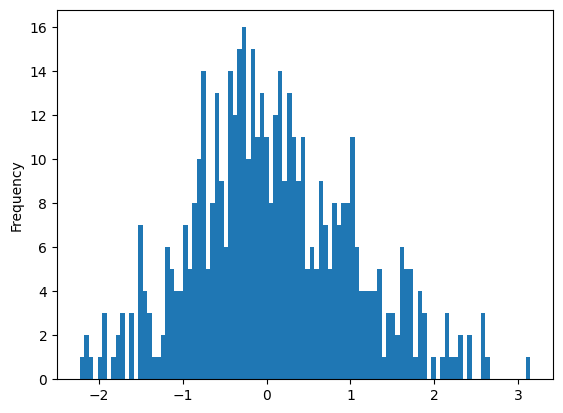

In [14]:
(preds-ys).plot.hist(bins=100)

corr: 0.7097646086857045
mae: 0.7501544364349256


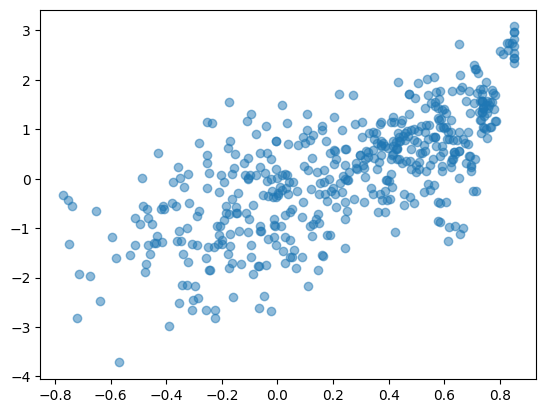

In [15]:
tmp=pd.DataFrame({
    "ys":ys,
    "preds":preds
})
plt.scatter(preds,ys,marker='o',alpha=0.5)
print("corr:",tmp.corr().iloc[0,1])
print("mae:",(preds-ys).abs().mean())

In [16]:
torch.save(model.state_dict(), "rgcn_saved_model.pth")
saved_model=RGCN()
saved_model.load_state_dict(torch.load("rgcn_saved_model.pth"))

<All keys matched successfully>